In [112]:
%load_ext autoreload
%autoreload 2

from recording import Recording
from auxiliary import DataHandler

import numpy as np
import pandas as pd

import librosa

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
sns.set(font='serif',style='ticks',context='talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
dh = DataHandler()

# Visualize Spectral Features

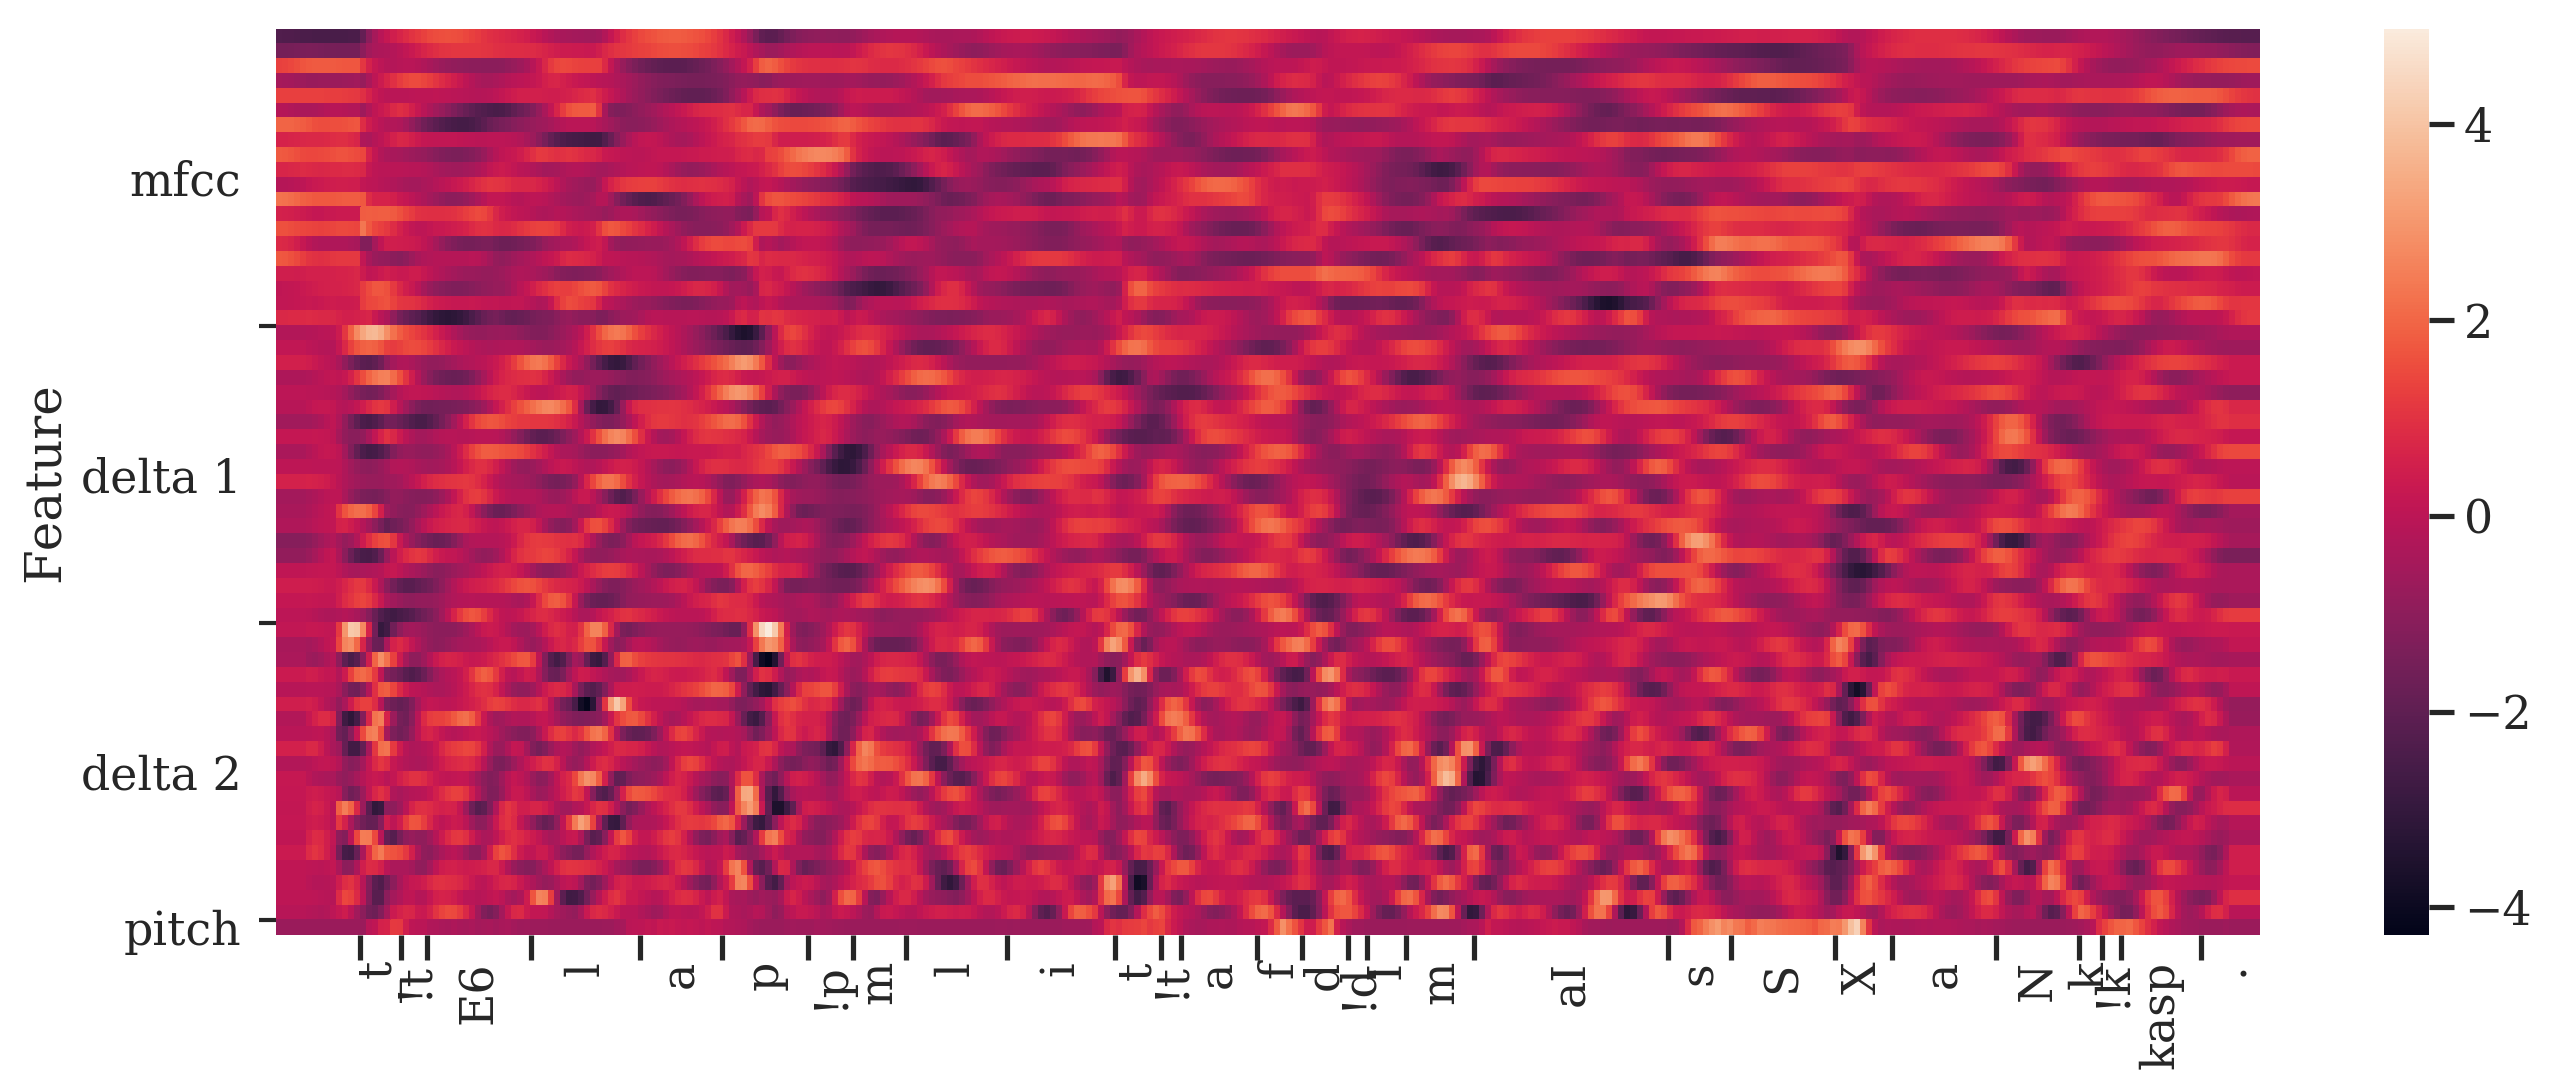

In [113]:
rec = Recording('03a01Fa')

t_start,t_stop,phoneme = [],[],[]
for i,row in rec.df_tags.iterrows():
    if row.phoneme != '':
        t_start.append(row.t_start)
        t_stop.append(row.t_stop)
        phoneme.append(row.phoneme)
    else:
        t_stop[-1] = row.t_stop
        
df_tags = pd.DataFrame({
    't_start': t_start,
    't_stop': t_stop,
    'phoneme': phoneme
})

features = np.vstack([rec.mfcc_cepstrum,rec.mfcc_delta1,rec.mfcc_delta2,rec.pitch_features(rec.raw_signal)])

fig,ax = plt.subplots(figsize=(16,6),dpi=200)
sns.heatmap(((features.T-np.mean(features,axis=1))/np.std(features,axis=1)).T,ax=ax)

ax.set_yticks([10,30,50,60.5])
ax.set_yticklabels(['mfcc','delta 1','delta 2','pitch'])
minor_locator = ticker.AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)

ax.yaxis.set_ticks_position
mid_points = np.array([(row.t_start+row.t_stop)/2 for _,row in df_tags.iterrows()])
mid_points = mid_points*rec.mfcc_cepstrum.shape[1]/df_tags.t_stop.values[-1]
x_tick_pos = df_tags.t_start.values*rec.mfcc_cepstrum.shape[1]/df_tags.t_stop.values[-1]

ax.set_xticks(x_tick_pos)
ax.set_xticklabels([])

ax.xaxis.set_minor_locator(ticker.FixedLocator(mid_points))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(df_tags.phoneme))

ax.set_ylabel('Feature')
for ticklabel in ax.get_ymajorticklabels():
    ticklabel.set_rotation(0)
for tick in ax.yaxis.get_majorticklines():
    tick.set_visible(0)
for tick in ax.xaxis.get_minorticklines():
    tick.set_visible(0)
for ticklabel in ax.get_xminorticklabels():
    ticklabel.set_rotation(90)
ax.yaxis.grid(which='minor')

# Performance

### Table

In [131]:
df_scores_1 = pd.read_csv('results/scores_1.csv',index_col=0)
df_scores_2 = pd.read_csv('results/scores_2.csv',index_col=0)
df_scores_3 = pd.read_csv('results/scores_3.csv',index_col=0)

In [132]:
for id in df_scores_1.index:
    print('s%s & %.2f & %.2f & %.2f \\\\ \\hline'%(id,df_scores_1.mean(axis=1)[id],df_scores_2.mean(axis=1)[id],df_scores_3.mean(axis=1)[id]))

s3 & 0.58 & 0.46 & 0.67 \\ \hline
s8 & 0.56 & 0.41 & 0.37 \\ \hline
s9 & 0.53 & 0.62 & 0.58 \\ \hline
s10 & 0.62 & 0.40 & 0.62 \\ \hline
s11 & 0.50 & 0.42 & 0.52 \\ \hline
s12 & 0.66 & 0.64 & 0.61 \\ \hline
s13 & 0.68 & 0.43 & 0.52 \\ \hline
s14 & 0.62 & 0.60 & 0.68 \\ \hline
s15 & 0.48 & 0.42 & 0.59 \\ \hline
s16 & 0.49 & 0.63 & 0.57 \\ \hline


In [137]:
print(df_scores_1.values.mean(),df_scores_1.values.std())
print(df_scores_2.values.mean(),df_scores_2.values.std())
print(df_scores_3.values.mean(),df_scores_3.values.std())

0.5722536492111904 0.07731969729085984
0.5032661885777634 0.10807664336294767
0.5719268665223971 0.08886431373223277


### Confusion matrices

In [135]:
import pickle, itertools
with open('results/cms_1.pkl','rb') as f:
    df_cms_1 = pd.DataFrame(pickle.load(f))
with open('results/cms_2.pkl','rb') as f:
    df_cms_2 = pd.DataFrame(pickle.load(f))
with open('results/cms_3.pkl','rb') as f:
    df_cms_3 = pd.DataFrame(pickle.load(f))

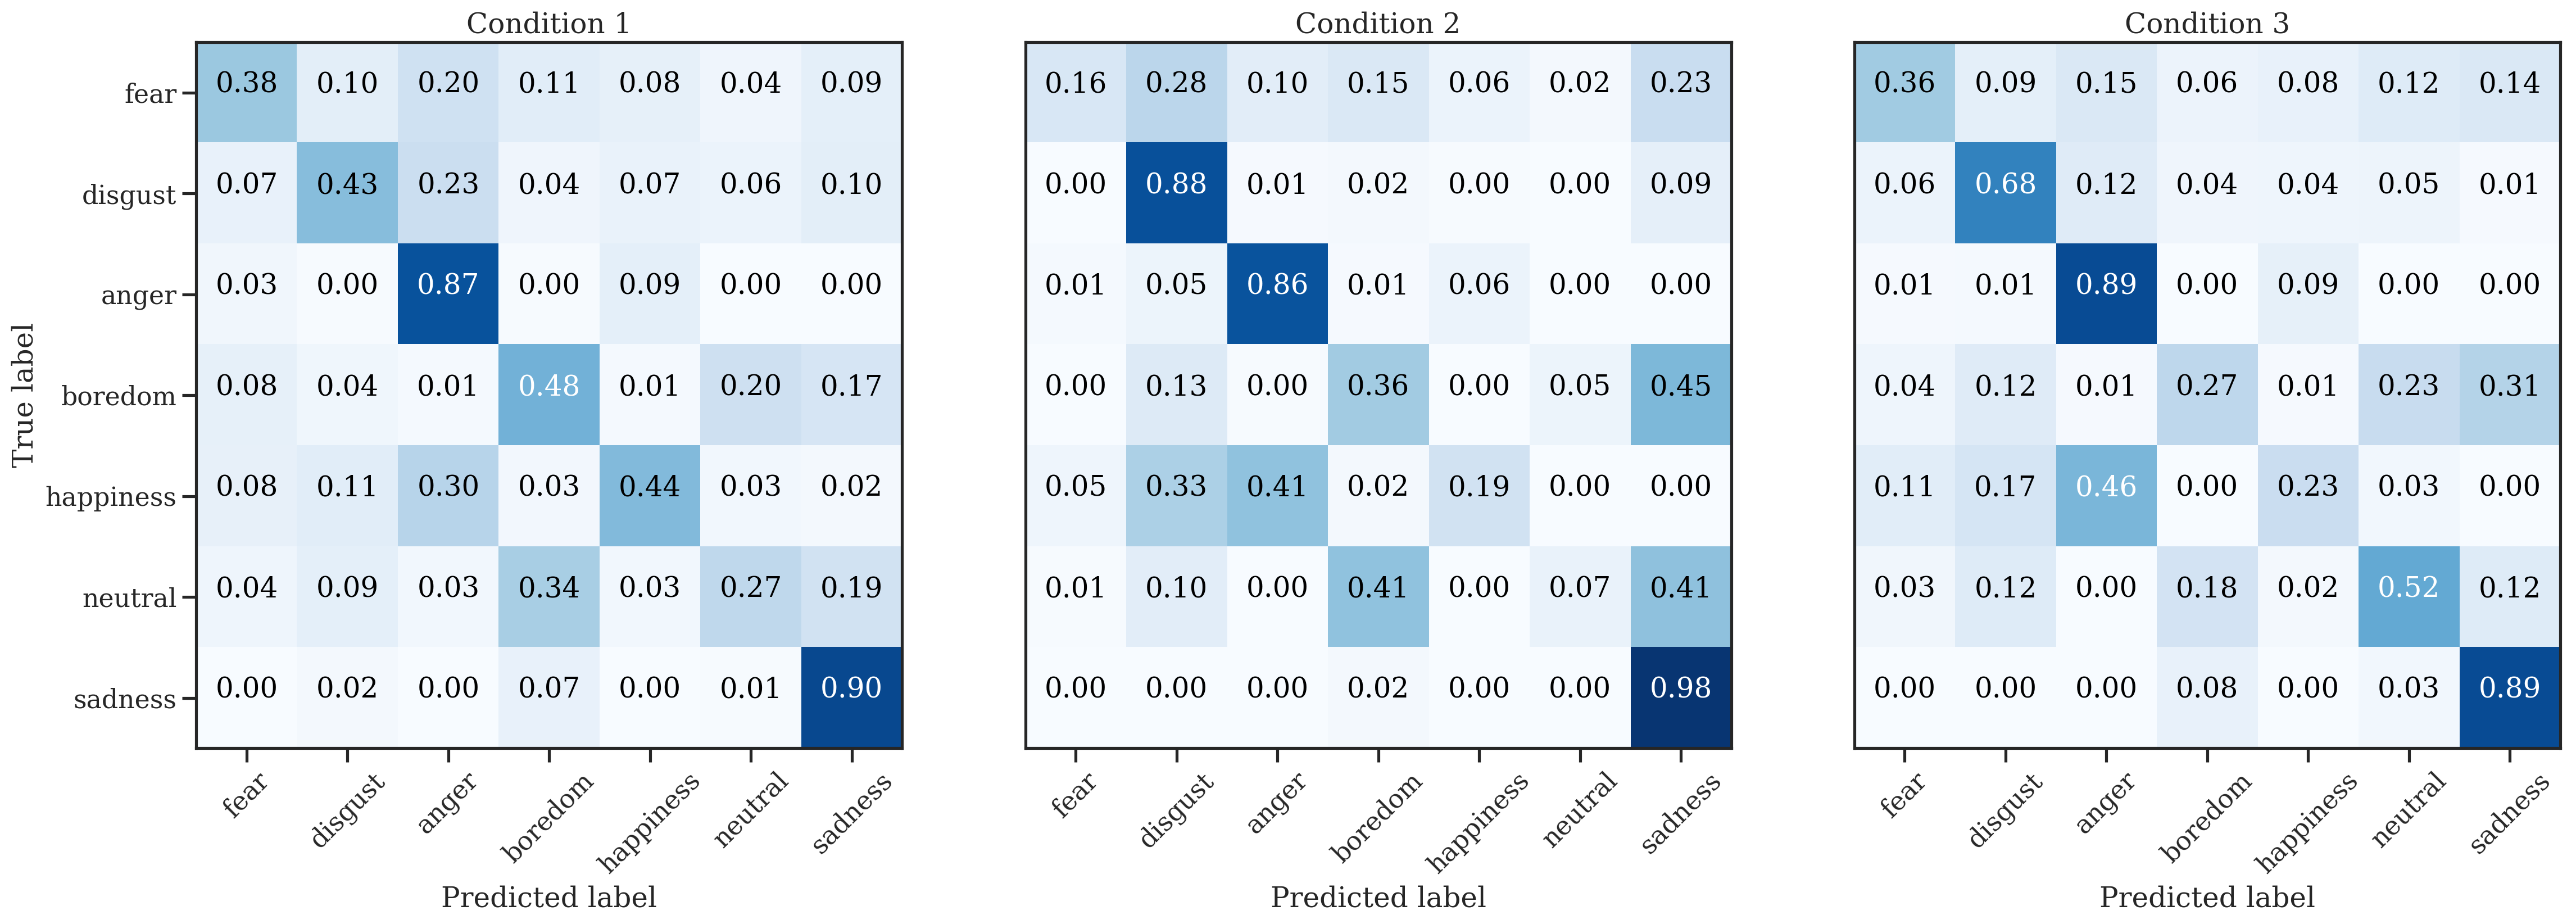

In [136]:
def plot_confusion_matrix(cm,ax,classes,title):
    ax.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues,vmin=0,vmax=1)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    thresh = cm.max() / 2.
    fmt = '.2f'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
def get_normed_cm(df):
    cms = [x for x in df.values.flatten() if x.shape == (7,7)]
    summed_cm = np.sum(cms,axis=0)
    return summed_cm/summed_cm.sum(axis=1)[:, np.newaxis]

fig,ax = plt.subplots(ncols=3,figsize=(24,8),dpi=200)
classes = [list(dh.emotion_map.values())[i] for i in range(0,7)]
plot_confusion_matrix(get_normed_cm(df_cms_1),ax=ax[0],classes=classes,title='Condition 1')
plot_confusion_matrix(get_normed_cm(df_cms_2),ax=ax[1],classes=classes,title='Condition 2')
plot_confusion_matrix(get_normed_cm(df_cms_3),ax=ax[2],classes=classes,title='Condition 3')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[1].set_ylabel('')
ax[2].set_ylabel('')
plt.tight_layout()